In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# SQLite3 버전 문제 해결: Chroma는 SQLite3 3.35.0 이상이 필요하지만 시스템에는 낮은 버전이 설치되어 있음
# pysqlite3-binary를 사용하여 더 높은 버전의 SQLite3을 제공
import sys
import pysqlite3
# 기존 sqlite3 모듈을 pysqlite3으로 대체
sys.modules['sqlite3'] = pysqlite3
print(f"Using SQLite version: {pysqlite3.sqlite_version}")

Using SQLite version: 3.46.1


In [3]:
import chromadb
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

# ChromaDB 클라이언트를 생성합니다.
client = chromadb.PersistentClient(path='./brief')


embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

# 컬랙션이 이미 존재할 때는 Chroma 클래스 생성자 사용하여 객체 생성
vector_store = Chroma(
    client=client,
    embedding_function=embedding_function,
    collection_name = 'brief'
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [4]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document


class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [5]:
def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o")

In [7]:
# Create a LANGSMITH_API_KEY in Settings > API Keys
from langsmith import Client
from langchain_openai import ChatOpenAI

client = Client()
generate_prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)
llm = ChatOpenAI(model="gpt-4o")

In [8]:
def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | llm
    response = rag_chain.invoke({'context': context, 'question': query})
    return {'answer': response}

In [9]:
# Create a LANGSMITH_API_KEY in Settings > API Keys
from langsmith import Client
client = Client()
relevance_doc_prompt = client.pull_prompt("langchain-ai/rag-document-relevance", include_model=True)

In [10]:
from typing import Literal

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    query = state['query']
    context = state['context']
    relevance_doc_chain = relevance_doc_prompt | llm
    response = relevance_doc_chain.invoke({'question': query, 'documents': context})
    if response['Score'] == 1:
        return 'relevant'

    return 'irrelevant'

In [11]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['LLM -> 생성형AI', '돈 관련 단위 -> 달러', '엔스로픽 -> 엔스롭픽']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고 우리의 사전을 참고해서 사용자의 질문을 변경해주세요
사전 : {dictionary}
질문 : {{query}}
                                              """)

def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query})
    return {'query': response}

In [12]:
# Create a LANGSMITH_API_KEY in Settings > API Keys
from langsmith import Client
from langchain_core.prompts import PromptTemplate
client = Client()
hallucination_promt = client.pull_prompt("langchain-ai/rag-answer-hallucination", include_model=True)


def check_hallucination(state: AgentState) -> Literal['hallucinated', 'not hallucinated']:
    answer = state['answer']
    context = state['context']
    print(f'context == {context}')
    hallucination_chain = hallucination_promt | llm
    response = hallucination_chain.invoke({'student_answer': answer, 'documents': context})
    print(f'hallucination response : {response}')
    if response['Score'] == 1:
        return 'not hallucinated'

    return 'hallucinated'

In [13]:
query = '구글이 엔스로픽에 투자한 금액은 얼마인가요?'
context = retriever.invoke(query)

generate_state = {'query': query, 'context': context}
answer = generate(generate_state)

print(f'answer == {answer}')

hallucination_state = {'answer': answer, 'context': context}
check_result = check_hallucination(hallucination_state)

answer == {'answer': AIMessage(content='구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의했으며, 이 중 5억 달러를 우선 투자했습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 2127, 'total_tokens': 2163, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 2048}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BrBA9FnhCb5o2OGe60gmxhSfg6Hnq', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8369c977-22ba-45d4-a0bf-6e64e2bd7bca-0', usage_metadata={'input_tokens': 2127, 'output_tokens': 36, 'total_tokens': 2163, 'input_token_details': {'audio': 0, 'cache_read': 2048}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}
context == [Document(id='8087dc56-3317-4651-a21f-3f58412e848e', metadata={'source': './documents/brief_2023년12월호_f

In [14]:
# Create a LANGSMITH_API_KEY in Settings > API Keys
from langsmith import Client
helpfulness_prompt = client.pull_prompt("langchain-ai/rag-answer-helpfulness", include_model=True)

def check_helpfulness_grader(state: AgentState) -> str:
    """
    사용자의 질문에 기반하여 생성된 답변의 유용성을 평가합니다.

    Args:
        state (AgentState): 사용자의 질문과 생성된 답변을 포함한 에이전트의 현재 state.

    Returns:
        str: 답변이 유용하다고 판단되면 'helpful', 그렇지 않으면 'unhelpful'을 반환합니다.
    """
    # state에서 질문과 답변을 추출합니다
    query = state['query']
    answer = state['answer']

    # 답변의 유용성을 평가하기 위한 체인을 생성합니다
    helpfulness_chain = helpfulness_prompt | llm

    # 질문과 답변으로 체인을 호출합니다
    response = helpfulness_chain.invoke({'question': query, 'student_answer': answer})

    # 점수가 1이면 'helpful'을 반환하고, 그렇지 않으면 'unhelpful'을 반환합니다
    if response['Score'] == 1:
        return 'helpful'

    return 'unhelpful'


# 노드는 state를 반환해야하기 때문에 아래와 같이 state만 반환하도록 만들었다.
def check_helpfulness(state: AgentState) -> AgentState:
    """
    유용성을 확인하는 자리 표시자 함수입니다.
    graph에서 conditional_edge를 연속으로 사용하지 않고 node를 추가해
    가독성을 높이기 위해 사용합니다

    Args:
        state (AgentState): 에이전트의 현재 state.

    Returns:
        AgentState: 변경되지 않은 state를 반환합니다.
    """
    # 이 함수는 현재 아무 작업도 수행하지 않으며 state를 그대로 반환합니다
    return state


In [15]:
query = '구글이 엔스로픽에 투자한 금액은 얼마인가요?'
context = retriever.invoke(query)

generate_state = {'query': query, 'context': context}
answer = generate(generate_state)

print(f'answer == {answer}')

helpfulness_state = {'answer': answer, 'query': query}
check_helpfulness(helpfulness_state)

answer == {'answer': AIMessage(content='구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의했으며, 이 중 5억 달러를 우선 투자했습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 2127, 'total_tokens': 2163, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 2048}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BrBAE6rV5FRYECEMm3kWurMQ8SyEl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--5ff2f120-c4c1-40a2-9565-c687965056a3-0', usage_metadata={'input_tokens': 2127, 'output_tokens': 36, 'total_tokens': 2163, 'input_token_details': {'audio': 0, 'cache_read': 2048}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}


{'answer': {'answer': AIMessage(content='구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의했으며, 이 중 5억 달러를 우선 투자했습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 2127, 'total_tokens': 2163, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 2048}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BrBAE6rV5FRYECEMm3kWurMQ8SyEl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--5ff2f120-c4c1-40a2-9565-c687965056a3-0', usage_metadata={'input_tokens': 2127, 'output_tokens': 36, 'total_tokens': 2163, 'input_token_details': {'audio': 0, 'cache_read': 2048}, 'output_token_details': {'audio': 0, 'reasoning': 0}})},
 'query': '구글이 엔스로픽에 투자한 금액은 얼마인가요?'}

In [16]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

In [17]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('check_helpfulness', check_helpfulness)

In [18]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelevant': END
    }
)
graph_builder.add_conditional_edges(
    'generate',
    check_hallucination,
    {
        'not hallucinated': 'check_helpfulness',
        'hallucinated': 'generate'
    }
)

graph_builder.add_conditional_edges(
    'check_helpfulness',
    check_helpfulness_grader,
    {
        'helpful': END,
        'unhelpful': 'rewrite'
    }
)
graph_builder.add_edge('rewrite', 'retrieve')

In [19]:
graph = graph_builder.compile()

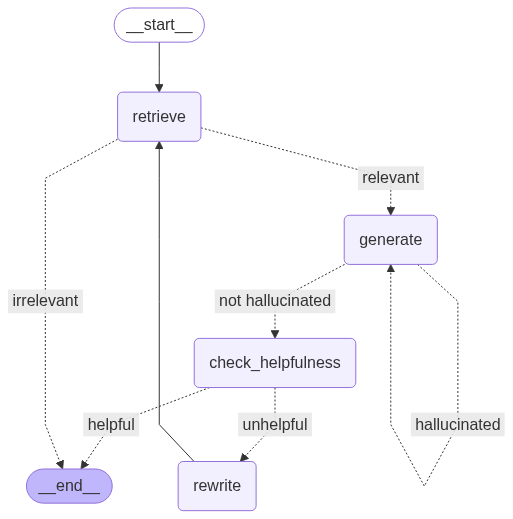

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
initial_state = {'query': '구글이 엔스로픽에 투자한 금액은 얼마인가요?'}
graph.invoke(initial_state)

context == [Document(id='8087dc56-3317-4651-a21f-3f58412e848e', metadata={'source': './documents/brief_2023년12월호_f.txt'}, page_content="아마존과 구글의 앤스롭픽 투자 앞서, 마이크로소프트는 차세대 AI 모델의 대표 주자인 오픈AI와 협력 확대\n\n마이크로소프트는 오픈AI에 앞서 투자한 30억 달러에 대해 2023년 1월 추가로 100억 달러를 투자하기로 하면서 오픈AI의 지분 49%를 확보했으며, 오픈AI는 마이크로소프트의 애저(Azure) 클라우드 플랫폼을 사용해 AI 모델을 훈련\n\n구글, 클라우드 경쟁력 강화를 위해 생성 AI 투자 확대\n\n구글은 수익성이 높은 클라우드 컴퓨팅 시장에서 아마존과 마이크로소프트를 따라잡고자 생성 AI를 통합한 기업 고객의 클라우드 지출 확대를 위해 AI 투자를 지속\n구글은 앤스롭픽 외에도 동영상 제작 도구를 개발하는 런웨이(Runway)와 오픈소스 소프트웨어 기업 허깅 페이스(Hugging Face)에도 투자\n구글은 첫 챗GPT의 기반 기술과 직접 경쟁할 수 있는 차세대 LLM '제미니( Gemini)'를 포함한 자율 시스템 개발에도 수십억 달러를 투자했으며, 2024년 제미니를 출시할 계획\n\n\n출처 : The Wall Street Journal, Google Commits $2 Billion in Funding to AI Startup Anthropic, 2023.10.27. Bloomberg, AI Startup Anthropic to Use Google Chips in Expanded Partnership, 2023.11.09.\n\nIDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망\nKEY Contents\n\nIDC에 따르면 AI 소프트웨어 시장은 2027년 2,510억 달러로 성장하며, 생성 AI 플랫폼과 애플리케이션은 2027년까지 283억 달러의 매출을 창출할 전망\n2

{'query': '구글이 엔스로픽에 투자한 금액은 얼마인가요?',
 'context': [Document(id='8087dc56-3317-4651-a21f-3f58412e848e', metadata={'source': './documents/brief_2023년12월호_f.txt'}, page_content="아마존과 구글의 앤스롭픽 투자 앞서, 마이크로소프트는 차세대 AI 모델의 대표 주자인 오픈AI와 협력 확대\n\n마이크로소프트는 오픈AI에 앞서 투자한 30억 달러에 대해 2023년 1월 추가로 100억 달러를 투자하기로 하면서 오픈AI의 지분 49%를 확보했으며, 오픈AI는 마이크로소프트의 애저(Azure) 클라우드 플랫폼을 사용해 AI 모델을 훈련\n\n구글, 클라우드 경쟁력 강화를 위해 생성 AI 투자 확대\n\n구글은 수익성이 높은 클라우드 컴퓨팅 시장에서 아마존과 마이크로소프트를 따라잡고자 생성 AI를 통합한 기업 고객의 클라우드 지출 확대를 위해 AI 투자를 지속\n구글은 앤스롭픽 외에도 동영상 제작 도구를 개발하는 런웨이(Runway)와 오픈소스 소프트웨어 기업 허깅 페이스(Hugging Face)에도 투자\n구글은 첫 챗GPT의 기반 기술과 직접 경쟁할 수 있는 차세대 LLM '제미니( Gemini)'를 포함한 자율 시스템 개발에도 수십억 달러를 투자했으며, 2024년 제미니를 출시할 계획\n\n\n출처 : The Wall Street Journal, Google Commits $2 Billion in Funding to AI Startup Anthropic, 2023.10.27. Bloomberg, AI Startup Anthropic to Use Google Chips in Expanded Partnership, 2023.11.09.\n\nIDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망\nKEY Contents\n\nIDC에 따르면 AI 소프트웨어 시장은 2027년 2,510억 달러로 성장하며, 생성 AI 플랫폼과